In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import os, sys, warnings, pytz
from datetime import datetime
warnings.filterwarnings("ignore")
timezone = pytz.timezone('America/Chicago')
from matplotlib import pyplot as plt
from scipy.stats import norm, dirichlet, invgamma, truncnorm, beta, gamma
from sklearn.model_selection import train_test_split
from scipy.stats import probplot

In [2]:
#read in the raw data and immediately remove non balls in play to save memory. Only go back to 2020 to save time when training models
from google.colab import drive
drive.mount('/drive')

raw22= pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw22.csv')
raw22 = raw22.loc[raw22['type'] == 'X']

raw21 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw21.csv')
raw21 = raw21.loc[raw21['type'] == 'X']

raw20 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw20.csv')
raw20 = raw20.loc[raw20['type'] == 'X']

raw19 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw19.csv')
raw19 = raw19.loc[raw19['type'] == 'X']

raw23 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw23.csv')
raw23 = raw23.loc[raw23['type'] == 'X']

Mounted at /drive


In the following cell, I prep the data the exact same way that I did when I learned the bip dists for the sloan paper. I know it's the exact same because I copy and pasted the code.

In [3]:
#combine
all_data = pd.concat((raw23, raw22, raw21, raw20, raw19))

del raw22
del raw21
del raw20
del raw23
del raw19

#we only want balls in play with non-null measurements
all_data = all_data.loc[all_data['type'] == 'X']
all_data = all_data.dropna(subset = ['hc_x', 'hc_y', 'launch_speed', 'launch_angle', 'hit_distance_sc'])

#one hot encode handedness
pit_hand = pd.get_dummies(all_data['p_throws'], drop_first = False)
bat_hand = pd.get_dummies(all_data['stand'], drop_first = False)
all_data['pit_handR'] = pit_hand['R']
all_data['bat_handR'] = bat_hand['R']

#hit direction
all_data['x'] = all_data.hc_x.values - 125.42
all_data['y'] = 198.27 - all_data.hc_y.values
all_data['hit_direction'] = np.arctan2(all_data.x.values, all_data.y.values) * 180/np.pi
#scale hit direction by -1 for lefties so we can consider all hitters at the same time
all_data.loc[all_data.bat_handR == 0, 'hit_direction'] *= -1

#remove extreme angles.
all_data = all_data.loc[np.abs(all_data.hit_direction) < 55]

#shift and scale so that hit directions are between 0 and 1
all_data['hd'] = (all_data.hit_direction.values + 55) / 110

#define hit direction type
all_data['is_oppo'] = 0
all_data.loc[all_data.hit_direction > 0, 'is_oppo'] = 1
all_data['is_pull'] = 1-all_data.is_oppo.values

#launch angle type
all_data['la_type'] = 0 #gb
all_data.loc[(all_data.launch_angle > 10) & (all_data.launch_angle <= 25), 'la_type'] = 1 #ld
all_data.loc[(all_data.launch_angle > 25) & (all_data.launch_angle <= 50), 'la_type'] = 2 #fb
all_data.loc[all_data.launch_angle > 50, 'la_type'] = 3 #pu
all_data['is_gb'] = 0
all_data['is_ld'] = 0
all_data['is_fb'] = 0
all_data['is_pu'] = 0
all_data.loc[all_data.la_type == 0, 'is_gb'] = 1
all_data.loc[all_data.la_type == 1, 'is_ld'] = 1
all_data.loc[all_data.la_type == 2, 'is_fb'] = 1
all_data.loc[all_data.la_type == 3, 'is_pu'] = 1

#max ev minus ev
max_ev = 123.
all_data['ev2'] = max_ev - all_data.launch_speed.values

#batterid/hand
all_data['batter_id_hand'] = all_data.batter.astype(str) + '-' + all_data.bat_handR.astype(str)

#keep only the necessary columns
# all_data = all_data[['pitch_type', 'game_date', 'batter', 'batter_id_hand', 'home_team', 'away_team',
#                      'balls', 'strikes', 'game_year', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up',
#                      'inning', 'launch_speed', 'launch_angle', 'if_fielding_alignment', 'of_fielding_alignment', 'pit_handR',
#                      'bat_handR', 'x', 'y', 'hit_direction', 'hd', 'is_oppo', 'is_pull', 'la_type', 'is_gb',
#                      'is_ld', 'is_fb', 'is_pu', 'ev2']]

#batter indices: we need indices for the batter and handedness so that we handle switch hitters appropriately
batter_indices = pd.DataFrame({'batter_id_hand':np.sort(all_data.batter_id_hand.unique())})
batter_indices['batter_index'] = batter_indices.index.values
train = all_data.merge(batter_indices, on = 'batter_id_hand')

In [4]:
#New code: define a more general pitch type
train['pitch_type_category'] = 'NA'

#sweepers (ST), Slurves (SV), Sliders (SL), Screwballs (SC),
#knuckler curves (KC), and Curveball (CU) are all 'breaking balls
train.loc[train.pitch_type.isin(['ST', 'SV', 'SL', 'SC', 'KC', 'CU']), 'pitch_type_category'] = 'BreakingBall'

#cutter (FC), Four seam fastball (FF), Sinker (SI) are all fastballs
train.loc[train.pitch_type.isin(['FC', 'FF', 'SI']), 'pitch_type_category'] = 'Fastball'

#changeup (CH), forkball (FO), splitter (FS) are off-speed
train.loc[train.pitch_type.isin(['CH', 'FO', 'FS']), 'pitch_type_category'] = 'Off-speed'

#any other pitch type is weird, so I won't count it. These are the eephus's, Knuckleballs, and nan pitch types. Screwball may belong in here too since few people throw it

In [5]:
#read in the batter distributions learned for the sloan project
final_indices = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/bip_distributions/final_dists_from_sloan_paper.csv')

### Plot 1: Nate Lowe plots, broken down by pitch type.

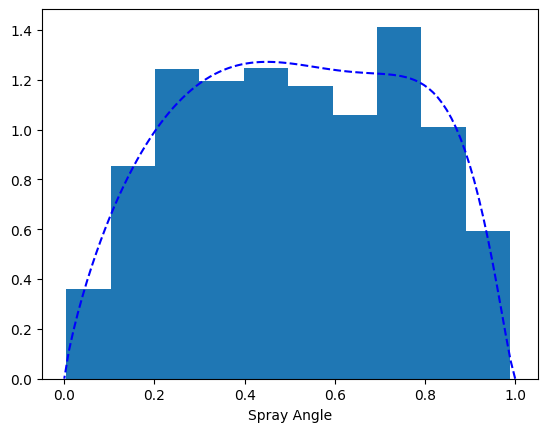

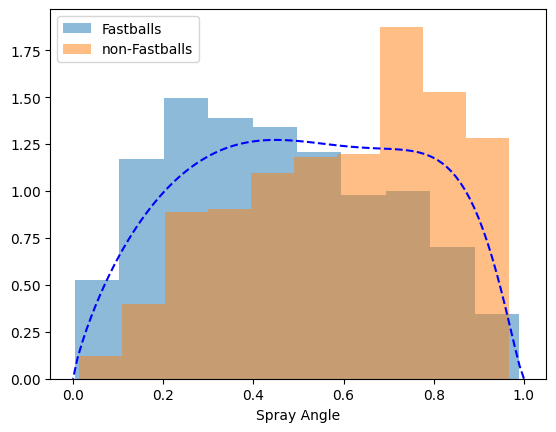

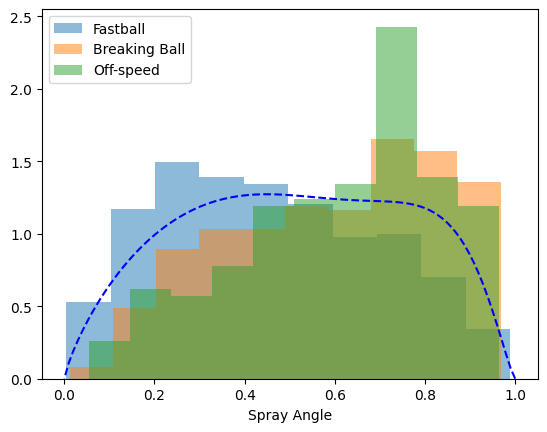

In [6]:
#get Lowe's learned distributions
lowe = final_indices.loc[final_indices.batter_id_hand == '663993-0']

#get his training data
low2= train.loc[train.batter == 663993]

#plot the learned spray angle dist over the training data. Flip the sign this time so it actually matches for the LHB
x = np.linspace(0,1,100)
plt.hist((1-low2.hd.values), density = True)
plt.plot((1-x), lowe.batter_w1.values[0] * beta(a = lowe.batter_alpha1.values[0], b = lowe.batter_beta1.values[0]).pdf(x) + lowe.batter_w2.values[0] * beta(a = lowe.batter_alpha2.values[0], b = lowe.batter_beta2.values[0]).pdf(x), 'b--')
plt.xlabel('Spray Angle')
plt.show()

#now plot the fastballs and non-fastballs seperately
plt.hist((1-low2.loc[low2.pitch_type_category == 'Fastball'].hd.values), density = True, alpha = 0.5, label = 'Fastballs')
plt.hist((1-low2.loc[low2.pitch_type_category != 'Fastball'].hd.values), density = True, alpha = 0.5, label = 'non-Fastballs')
plt.plot((1-x), lowe.batter_w1.values[0] * beta(a = lowe.batter_alpha1.values[0], b = lowe.batter_beta1.values[0]).pdf(x) + lowe.batter_w2.values[0] * beta(a = lowe.batter_alpha2.values[0], b = lowe.batter_beta2.values[0]).pdf(x), 'b--')
plt.xlabel('Spray Angle')
plt.legend()
plt.show()

#finally, plot all of the pitch type categories separately
plt.hist((1-low2.loc[low2.pitch_type_category == 'Fastball'].hd.values), density = True, alpha = 0.5, label = 'Fastball')
plt.hist((1-low2.loc[low2.pitch_type_category == 'BreakingBall'].hd.values), density = True, alpha = 0.5, label = 'Breaking Ball')
plt.hist((1-low2.loc[low2.pitch_type_category == 'Off-speed'].hd.values), density = True, alpha = 0.5, label = 'Off-speed')
plt.plot((1-x), lowe.batter_w1.values[0] * beta(a = lowe.batter_alpha1.values[0], b = lowe.batter_beta1.values[0]).pdf(x) + lowe.batter_w2.values[0] * beta(a = lowe.batter_alpha2.values[0], b = lowe.batter_beta2.values[0]).pdf(x), 'b--')
plt.xlabel('Spray Angle')
plt.legend()
plt.show()

These are exactly what I was hoping for. What these show is that for Nate Lowe, even though the learned distribution fits the data fairly well, it is clear that Lowe is more pull heavy than his fitted distribution would suggest when he hits a breaking ball or off-speed pitch, and he is more oppo heavy when he hits a fastball. We could make similar plots for the other hitters in the paper (McCormick, Bell, etc.) if we wanted to. But these plots will be great to make the argument that we likely benefit from pitcher specific positioning. For example, for a pitcher like Brock Burke who prideminatly throws his fastball, we may want to shift our fielders more oppo. For a pitcher like Lance McCullers who only throws his fastball 23% of the time and otherwise throws a breaking ball or off-speed, we may want to position more pull heavy. Additionally if we plan to attack a hitter more with fastballs with breaking balls then we may need to position more to the oppo side, and if we plan to attack with breaking balls, then we need to position more to the pull side. Note the Lowe spray angle plots were flipped for his left-handedness, so greater than 0 degrees is the right side of the infield in these plots.

Naturally, we expect that fastballs are going to be hit higher than the breaking balls and offspeed pitches because as we saw in the sloan paper, the more oppo balls tend to be hit higher. Let's see in the next cell.

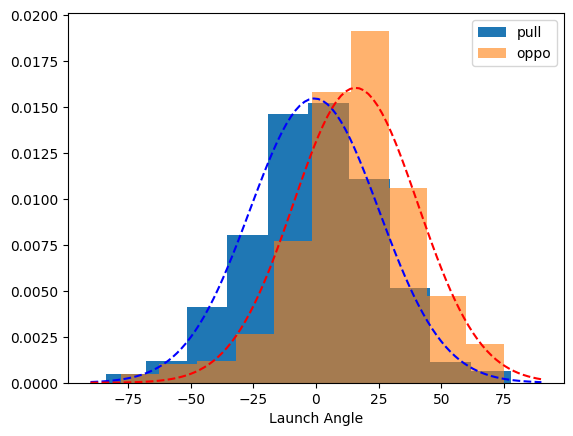

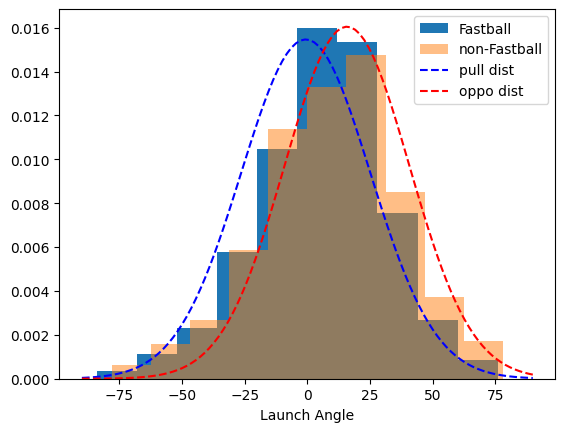

In [7]:
x = np.linspace(-90,90,100)
plt.hist(low2.loc[low2.is_pull == 1].launch_angle.values, density = True, label = 'pull')
plt.hist(low2.loc[low2.is_pull == 0].launch_angle.values, density = True, label = 'oppo', alpha = 0.6)
plt.plot(x, norm(loc = lowe.batter_mean_pull.values[0], scale = lowe.batter_sigma_pull.values[0]).pdf(x), 'b--')
plt.plot(x, norm(loc = lowe.batter_mean_oppo.values[0], scale = lowe.batter_sigma_oppo.values[0]).pdf(x), 'r--')
plt.legend()
plt.xlabel('Launch Angle')
plt.show()

plt.hist(low2.loc[low2.pitch_type_category == 'Fastball'].launch_angle.values, density = True, label = 'Fastball')
plt.hist(low2.loc[low2.pitch_type_category != 'Fastball'].launch_angle.values, density = True, label = 'non-Fastball', alpha = 0.5)
plt.plot(x, norm(loc = lowe.batter_mean_pull.values[0], scale = lowe.batter_sigma_pull.values[0]).pdf(x), 'b--', label = 'pull dist')
plt.plot(x, norm(loc = lowe.batter_mean_oppo.values[0], scale = lowe.batter_sigma_oppo.values[0]).pdf(x), 'r--', label = 'oppo dist')
plt.legend()
plt.xlabel('Launch Angle')
plt.show()

This is a little counterintuitive. Since Fastballs tend to be hit more oppo than breaking balls, we'd expect that they'd be hit higher as well since we found originally in the sloan paper that oppo balls tend to be hit higher. We aren't seeing that here though. Instead, we are seeing that fastballs are actually a little bit lower, at least for Nate Lowe. So I would say we probably don't include these plots in the paper, but maybe we make the argument that the effect that the pitch has on bip distributions is a bit more nuanced than what we had before when we just broke it down by pull and oppo, so we need the neural net to learn the more complicated function.

What if we look at launch angle by pitch height? Next cell

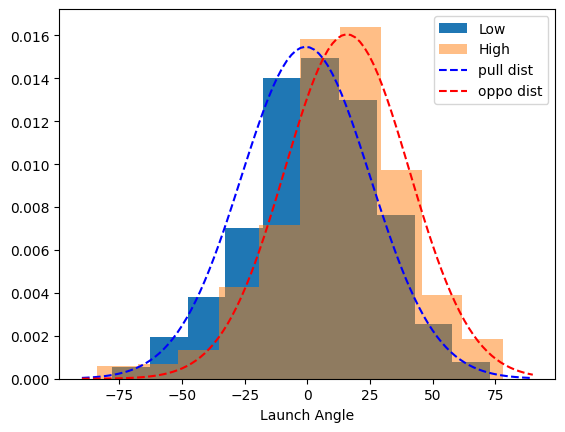

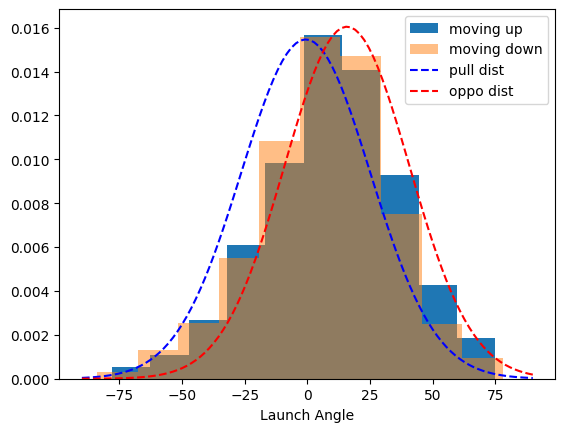

In [8]:
low2['mid_sz'] = (low2.sz_top.values + low2.sz_bot.values) / 2
low2['is_upper'] = 0
low2.loc[low2.plate_z > low2.mid_sz, 'is_upper'] = 1
plt.hist(low2.loc[low2.is_upper == 0].launch_angle.values, density = True, label = 'Low')
plt.hist(low2.loc[low2.is_upper == 1].launch_angle.values, density = True, label = 'High', alpha = 0.5)
plt.plot(x, norm(loc = lowe.batter_mean_pull.values[0], scale = lowe.batter_sigma_pull.values[0]).pdf(x), 'b--', label = 'pull dist')
plt.plot(x, norm(loc = lowe.batter_mean_oppo.values[0], scale = lowe.batter_sigma_oppo.values[0]).pdf(x), 'r--', label = 'oppo dist')
plt.legend()
plt.xlabel('Launch Angle')
plt.show()

low2['rising'] = 0
low2.loc[low2.pfx_z > 0, 'rising'] = 1
plt.hist(low2.loc[low2.rising == 0].launch_angle.values, density = True, label = 'moving up')
plt.hist(low2.loc[low2.rising == 1].launch_angle.values, density = True, label = 'moving down', alpha = 0.5)
plt.plot(x, norm(loc = lowe.batter_mean_pull.values[0], scale = lowe.batter_sigma_pull.values[0]).pdf(x), 'b--', label = 'pull dist')
plt.plot(x, norm(loc = lowe.batter_mean_oppo.values[0], scale = lowe.batter_sigma_oppo.values[0]).pdf(x), 'r--', label = 'oppo dist')
plt.legend()
plt.xlabel('Launch Angle')
plt.show()

This is awesome! This shows that Lowe's pull and oppo dists almost perfectly correspond to if the pitch was thrown above the midpoint of the strike zone are below it. So based on this, we can make the argument that the location of the pitch is a factor in where it ends up. Let's do the same plot but with horizontal plate location and spray angle.

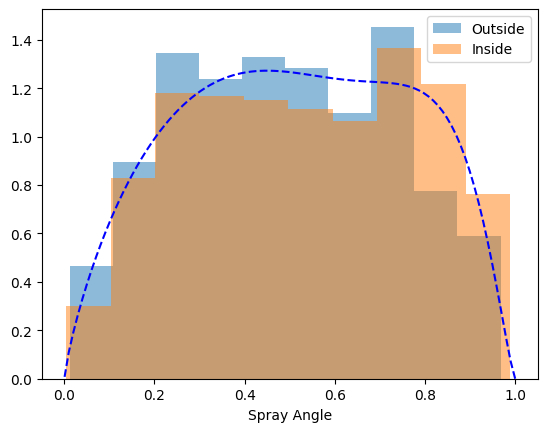

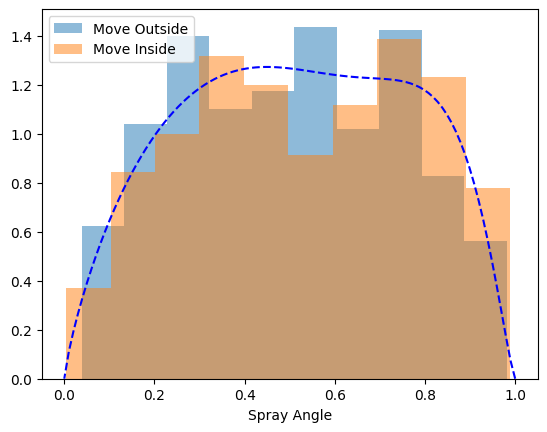

In [9]:
x = np.linspace(0,1,100)
low2['is_inside'] = 0
low2.loc[low2.plate_x > 0, 'is_inside'] = 1
plt.hist((1-low2.loc[low2.is_inside == 0].hd.values), density = True, alpha = 0.5, label = 'Outside')
plt.hist((1-low2.loc[low2.is_inside == 1].hd.values), density = True, alpha = 0.5, label = 'Inside')
plt.plot((1-x), lowe.batter_w1.values[0] * beta(a = lowe.batter_alpha1.values[0], b = lowe.batter_beta1.values[0]).pdf(x) + lowe.batter_w2.values[0] * beta(a = lowe.batter_alpha2.values[0], b = lowe.batter_beta2.values[0]).pdf(x), 'b--')
plt.xlabel('Spray Angle')
plt.legend()
plt.show()

#moving in or out
low2['move_inside'] = 0
low2.loc[low2.pfx_x > 0, 'move_inside'] = 1
plt.hist((1-low2.loc[low2.move_inside == 0].hd.values), density = True, alpha = 0.5, label = 'Move Outside')
plt.hist((1-low2.loc[low2.move_inside == 1].hd.values), density = True, alpha = 0.5, label = 'Move Inside')
plt.plot((1-x), lowe.batter_w1.values[0] * beta(a = lowe.batter_alpha1.values[0], b = lowe.batter_beta1.values[0]).pdf(x) + lowe.batter_w2.values[0] * beta(a = lowe.batter_alpha2.values[0], b = lowe.batter_beta2.values[0]).pdf(x), 'b--')
plt.xlabel('Spray Angle')
plt.legend()
plt.show()

Looks like inside/outside is less predictive of spray angle than high/low is of launch angle. Lastly let's look at exit speeds.

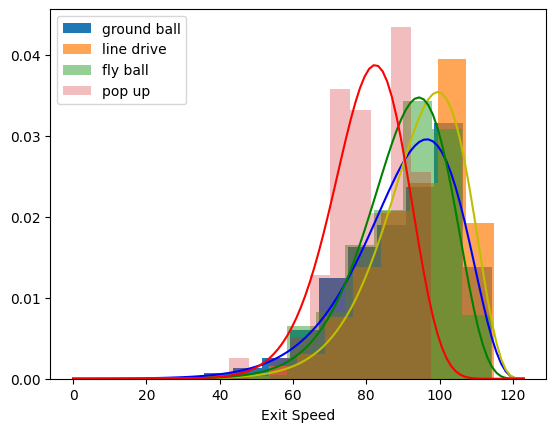

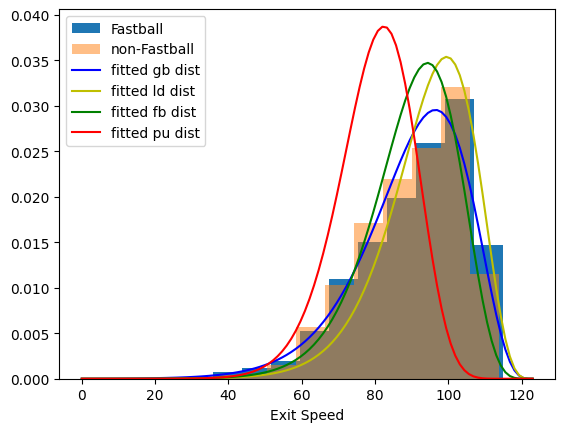

In [10]:
x = np.linspace(0,max_ev,100)
plt.hist(low2.loc[low2.is_gb == 1].launch_speed.values, density = True, label = 'ground ball')
plt.hist(low2.loc[low2.is_ld == 1].launch_speed.values, density = True, label = 'line drive', alpha = 0.7)
plt.hist(low2.loc[low2.is_fb == 1].launch_speed.values, density = True, label = 'fly ball', alpha = 0.5)
plt.hist(low2.loc[low2.is_pu == 1].launch_speed.values, density = True, label = 'pop up', alpha = 0.3)
plt.plot(x, gamma(a = lowe.batter_a_gb.values[0], scale = lowe.batter_s_gb.values[0]).pdf(max_ev - x), 'b-')
plt.plot(x, gamma(a = lowe.batter_a_ld.values[0], scale = lowe.batter_s_ld.values[0]).pdf(max_ev - x), 'y-')
plt.plot(x, gamma(a = lowe.batter_a_fb.values[0], scale = lowe.batter_s_fb.values[0]).pdf(max_ev - x), 'g-')
plt.plot(x, gamma(a = lowe.batter_a_pu.values[0], scale = lowe.batter_s_pu.values[0]).pdf(max_ev - x), 'r-')
plt.legend()
plt.xlabel('Exit Speed')
plt.show()

#now break it down by pitch type
plt.hist(low2.loc[low2.pitch_type_category == 'Fastball'].launch_speed.values, density = True, label = 'Fastball')
plt.hist(low2.loc[low2.pitch_type_category != 'Fastball'].launch_speed.values, density = True, label = 'non-Fastball', alpha = 0.5)
plt.plot(x, gamma(a = lowe.batter_a_gb.values[0], scale = lowe.batter_s_gb.values[0]).pdf(max_ev - x), 'b-', label = 'fitted gb dist')
plt.plot(x, gamma(a = lowe.batter_a_ld.values[0], scale = lowe.batter_s_ld.values[0]).pdf(max_ev - x), 'y-', label = 'fitted ld dist')
plt.plot(x, gamma(a = lowe.batter_a_fb.values[0], scale = lowe.batter_s_fb.values[0]).pdf(max_ev - x), 'g-', label = 'fitted fb dist')
plt.plot(x, gamma(a = lowe.batter_a_pu.values[0], scale = lowe.batter_s_pu.values[0]).pdf(max_ev - x), 'r-', label = 'fitted pu dist')
plt.legend()
plt.xlabel('Exit Speed')
plt.show()

Looks like, at least for Lowe, pitch type is not really predictive of launch speed.

### Plots 2: Whole population, not just Lowe

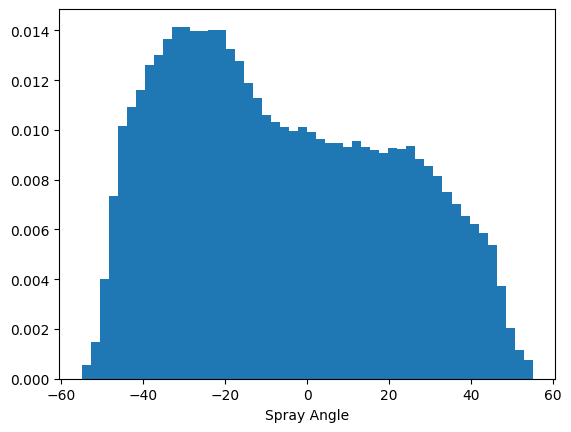

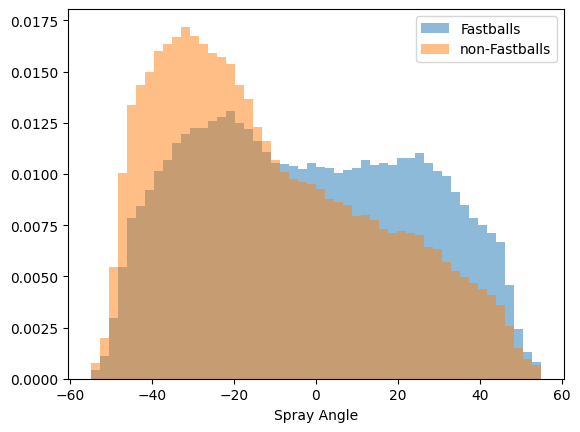

In [11]:
#plot the learned spray angle dist over the training data. Flip the sign this time so it actually matches for the LHB
plt.hist(train.hit_direction.values, density = True, bins = 50)
plt.xlabel('Spray Angle')
plt.show()

#now plot the fastballs and non-fastballs seperately
plt.hist(train.loc[train.pitch_type_category == 'Fastball'].hit_direction.values, density = True, alpha = 0.5, label = 'Fastballs', bins = 50)
plt.hist(train.loc[train.pitch_type_category != 'Fastball'].hit_direction.values, density = True, alpha = 0.5, label = 'non-Fastballs', bins = 50)
plt.xlabel('Spray Angle')
plt.legend()
plt.show()

I think this is convincing enough on it's own to show that pitch type has an effect on spray angle, but I could also do a t-test or some other distribution comparison test if we need more evidence.

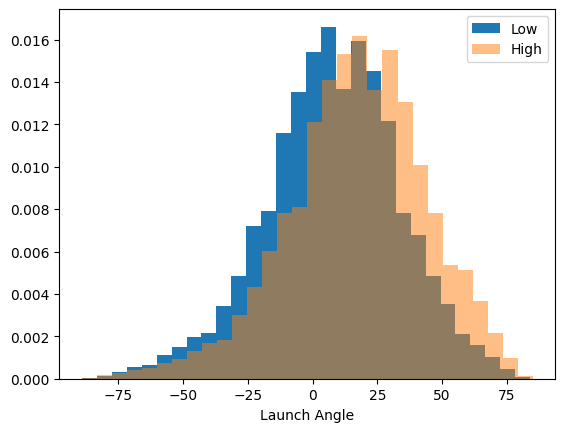

In [12]:
train['mid_sz'] = (train.sz_top.values + train.sz_bot.values) / 2
train['is_upper'] = 0
train.loc[train.plate_z > train.mid_sz, 'is_upper'] = 1
plt.hist(train.loc[train.is_upper == 0].launch_angle.values, density = True, label = 'Low', bins = 30)
plt.hist(train.loc[train.is_upper == 1].launch_angle.values, density = True, label = 'High', alpha = 0.5, bins = 30)
plt.legend()
plt.xlabel('Launch Angle')
plt.show()

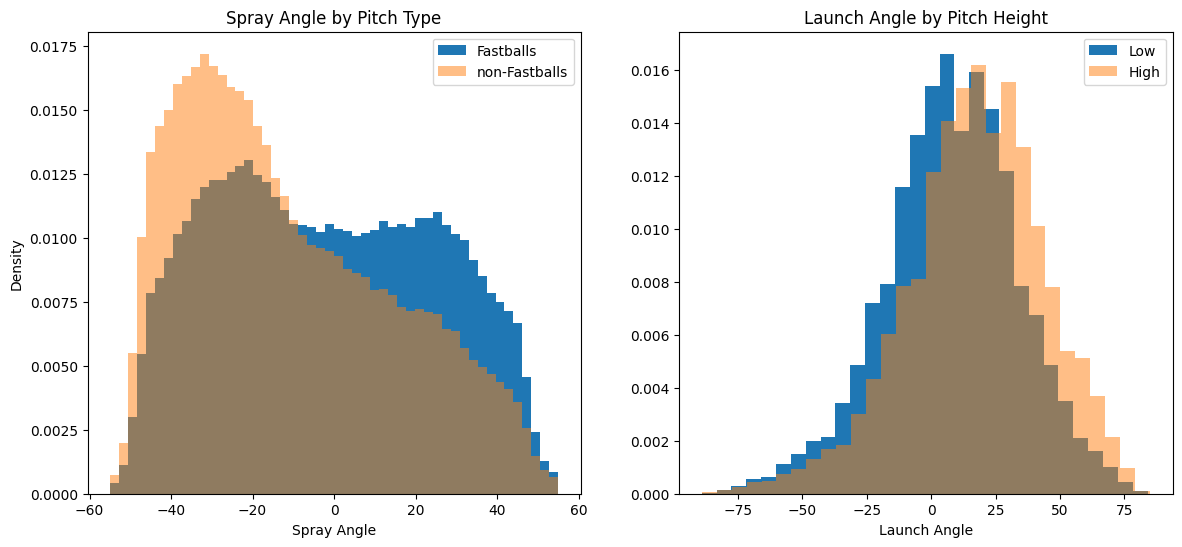

In [13]:
#prettier plot for the paper
fig = plt.figure(figsize = (14,6))
ax1 = plt.subplot(121)
ax1.hist(train.loc[train.pitch_type_category == 'Fastball'].hit_direction.values, density = True, alpha = 1, label = 'Fastballs', bins = 50)
ax1.hist(train.loc[train.pitch_type_category != 'Fastball'].hit_direction.values, density = True, alpha = 0.5, label = 'non-Fastballs', bins = 50)
ax1.legend()
ax1.set_title('Spray Angle by Pitch Type')
ax1.set_xlabel('Spray Angle')
ax1.set_ylabel('Density')
ax2 = plt.subplot(122)
plt.hist(train.loc[train.is_upper == 0].launch_angle.values, density = True, label = 'Low', bins = 30)
plt.hist(train.loc[train.is_upper == 1].launch_angle.values, density = True, label = 'High', alpha = 0.5, bins = 30)
ax2.legend()
ax2.set_title('Launch Angle by Pitch Height')
ax2.set_xlabel('Launch Angle')
plt.show()

Again, I think this evidence is good enough on it's own although it's less strong than the spray angles by pitch type evidence, but I could also do a t-test or a ks test or something like that if we want more evidence.

The other good argument we can make is actually just based on figure 3 in the paper where we make the claim that exit speed is conditionally independent of spray angle given launch angle. If we're being honest, in those plots it looks like the oppo exit speeds are still lower than the pull exit speeds, even after breaking down by launch angle type.